In [170]:
import os
import sys
import random
import random
import itertools

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import orthogonal_procrustes
from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_euler_angles, random_rotation
from pytorch3d.transforms import quaternion_to_matrix
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

from solver import Up2P
from utils.rotation_utils import validate_sol, get_rotation_error, get_upward_with_dev, get_random_upward

In [2]:
# config
from dataclasses import dataclass

@dataclass
class Config:
    max_depth: float = 10.
    img_width: int = 640
    img_height: int = 640
    focal_length: int = 3 * (img_width * 0.5) / np.tan(60.0 * np.pi / 180.0);
    min_depth: float = 0.1
    max_depth: float = 10
    inliers_ratio: float = 0.8
    outlier_dist: float = 30.
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    pixel_noise: float = 2.
    
conf = Config()
print(conf)

Config(max_depth=10, img_width=640, img_height=640, focal_length=554.2562584220409, min_depth=0.1, inliers_ratio=0.8, outlier_dist=30.0, pixel_noise=2.0)


In [3]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_random_image_point(conf: Config):
    x = random.uniform(0, conf.img_width)
    y = random.uniform(0, conf.img_height)
    x = torch.tensor([x, y], dtype=torch.float64)    
    return x

def to_homogeneous(x):
    return torch.cat([x, torch.ones(1)])

def to_camera_coords(x: torch.tensor, conf: Config = conf):
    x = to_homogeneous(x)
    
    x[0] -= conf.img_width // 2
    x[1] -= conf.img_height // 2
    x[:2] /= conf.focal_length
    x /= x.norm()
    
    return x

def generate_correspondence(x: torch.tensor, conf: Config):
    x = to_camera_coords(x, conf)
    x *= random.uniform(conf.min_depth, conf.max_depth)
    
    assert x.shape == (3,)    
    return x

def transform_correspondence(X: torch.tensor, R: torch.tensor, t: torch.tensor):
    return R @ X + t

def _generate_example(R, t, conf: Config = conf):
    x1, x2 = get_random_image_point(conf), get_random_image_point(conf)
    X1, X2 = generate_correspondence(x1.clone(), conf),\
             generate_correspondence(x2.clone(), conf)
    X1, X2 = transform_correspondence(X1, R, t), transform_correspondence(X2, R, t)
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    if conf.pixel_noise != 0:
        x1noise = np.random.normal(0, conf.pixel_noise, 2)
        x2noise = np.random.normal(0, conf.pixel_noise, 2)
        x1 += x1noise
        x2 += x2noise
        assert x1[0] > 0 and x1[1] < conf.img_width
        assert x1[1] > 0 and x1[1] < conf.img_height

    return x1, x2, X1, X2 

# x: [2, ]
def generate_outlier(x, conf):
    out = get_random_image_point(conf)
    
    while ((out - x).norm() < conf.outlier_dist):
        out = get_random_image_point(conf)
        
    return out

def generate_examples(num_of_examples: int,
                      dev: tuple[float, float] = (0., 0.), conf: Config = conf):
    num_of_examples = num_of_examples // 2
    
    num_inliers = num_of_examples * conf.inliers_ratio
    num_outliers = num_of_examples - num_inliers
    
    if num_of_examples == 0:
        num_of_examples, num_inliers, num_outliers = 1, 1, 0
    
    R, rand_angle = get_random_upward(*dev)
    t = torch.rand(3, )
        
    # [TODO] [IMPORTANT]: under such generation we cannot get model where one of the points is an inlier
    xs, Xs, inliers = [], [], []
    for i in range(num_of_examples):
        x1, x2, X1, X2 = _generate_example(R, t)
        Xs.append((X1, X2))
        
        if i < num_inliers:
            xs.append((x1, x2))
            inliers.append(True)
        else:
            xs.append((generate_outlier(x1, conf), generate_outlier(x2, conf)))
            inliers.append(False)
            
    return xs, Xs, inliers, R, t, rand_angle

In [5]:
# X : (3, )
# R : (3, 3) - rotation matrix
# t : (3, ) - translation vector
def reproject(X, R, t, conf: Config = conf):
    translated = R.T @ (X - t)
    translated[:2] /= translated[2]
    translated[:2] *= conf.focal_length
    translated[0] += conf.img_width // 2
    translated[1] += conf.img_height // 2
    
    return translated[:2]

In [6]:
from solver import Up2P
def assert_correctness():
    solver = Up2P()
    xs, Xs, _, Rg, tg, _ = generate_examples(1)
    xs, Xs = xs[0], Xs[0]
    Re, te, err = None, None, None
    
    xsc = torch.zeros((2, 3))
    xsc[0] = to_camera_coords(xs[0], conf)
    xsc[1] = to_camera_coords(xs[1], conf)
    
    for R, t in solver(xsc, torch.stack(Xs)):
        rerr, terr = validate_sol(R, t, Rg, tg)
        print(t, tg)
        print(f"--------- R error: {rerr}, t error: {terr} ----------")  
        if err is None or rerr < err:
            err = rerr
            Re, te = R, t
            
    assert torch.all(torch.isclose(xs[0], reproject(Xs[0], Re, te, conf)))
        
assert_correctness()

tensor([0.6435, 0.5731, 0.5181], dtype=torch.float64) tensor([0.6279, 0.5445, 0.5360])
--------- R error: 0.3575723875703, t error: 0.037157529876624906 ----------
tensor([-1.6506, -2.8480, -0.3882], dtype=torch.float64) tensor([0.6279, 0.5445, 0.5360])
--------- R error: 60.46265743194288, t error: 4.189831374334264 ----------


In [147]:
def get_displacements(n: int = 52, dev: tuple[float, float] = (0, 0)):
    solver = Up2P()
    
    generated_from_inlier: bool = True
    xs, Xs, inliers, Rg, tg, rand_angle = generate_examples(n, dev)
    xsc = [(to_camera_coords(x[0].clone(), conf), to_camera_coords(x[1].clone(), conf)) for x in xs]
    
    solve_for = None
    sols = []
    while len(sols) == 0:
        solve_for = random.randint(0, len(xsc) - 1)
        sols = solver(torch.stack(xsc[solve_for]), torch.stack(Xs[solve_for]))
   
    if not inliers[solve_for]:
        generated_from_inlier = False
    
    validate_for = None
    while validate_for is None or validate_for == solve_for:
        validate_for = random.randint(0, len(xsc) - 1)
    
    R, t, err = None, None, None
    for sol in sols:
        Rc, tc = sol
        reprojected_x = reproject(Xs[validate_for][0], Rc, tc)
        gt_x = xs[validate_for][0]
        if err is None or (gt_x - reprojected_x).norm() < err:
            err = (gt_x - reprojected_x).norm()
            R, t = Rc, tc
            
            
    reprojected_x = reproject(Xs[validate_for][0], R, t)
    gt_x = xs[validate_for][0]
    
    if dev == (0, 0):
        assert err < 5e-2
        assert (gt_x - reprojected_x).norm() < 5e-2
    
    gt, proj, disp, inlier_disp = [], [], [], []
    
    for idx in range(len(Xs)):
        if idx == solve_for or idx == validate_for:
            continue
            
        inlier_disp.append(inliers[idx])
        for j in range(2):
            X, x = Xs[idx][j], xs[idx][j]
            reprojected_x = reproject(X, R, t)
            
            if dev == (0, 0):
                assert (x[:2] - reprojected_x[:2]).norm() < 1e-2, f"{(x[:2] - reprojected_x[:2]).norm()}"

            disp.append(x[:2] - reprojected_x[:2])
            gt.append(x[:2])
            proj.append(reprojected_x[:2])
        
    return gt, proj, disp, inlier_disp, rand_angle, generated_from_inlier

In [8]:
# TODO: run this for inliers with zero dev as test that everyghin works ok
# for i in tqdm(range(100)):
#     try:
#         _ = get_displacements(100, (0,  0))
#     except Exception as ex:
#         print(ex)

In [156]:
def plot_displacements(gt, proj, inlier_disp, conf):
    assert len(gt) == len(proj)
    assert len(gt)//2 == len(inlier_disp)
    
    # TODO: //2 is hacky, may introduce a bug later on
    
    good_idcs, bad_idcs = [], []
    for i in range(len(gt)):
        if inlier_disp[i // 2]:
            good_idcs.append(i)
        else:
            bad_idcs.append(i)

    X = np.array([float(elm[0]) - conf.img_width // 2 for elm in gt])
    Y = np.array([float(elm[1]) - conf.img_height // 2 for elm in gt])
    U = np.array([X[idx] + conf.img_width // 2 - float(elm[0]) for idx, elm in enumerate(proj)])
    V = np.array([Y[idx] + conf.img_height // 2 - float(elm[1]) for idx, elm in enumerate(proj)])

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=80)
    axes.quiver(X[good_idcs], Y[good_idcs], U[good_idcs], V[good_idcs],
                           color='b',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                          )

    axes.quiver(X[bad_idcs], Y[bad_idcs], U[bad_idcs], V[bad_idcs],
                           color='y',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                          )
    
    axes.quiver(np.mean(X[good_idcs]), np.mean(Y[good_idcs]), np.mean(U[good_idcs]), np.mean(V[good_idcs]),
                           color='g',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                          )
    
    axes.quiver(np.mean(X[bad_idcs]), np.mean(Y[bad_idcs]), np.mean(U[bad_idcs]), np.mean(V[bad_idcs]),
                           color='r',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                          )
    
    bh, _ = axes.plot([], [], [], color="b", label="Inlier displacements")
    yh, _ = axes.plot([], [], [], color="y", label="Oulier displacements")
    gh, _ = axes.plot([], [], [], color="g", label="Mean inlier displacement")
    rh, _ = axes.plot([], [], [], color="r", label="Mean outlier displacement")
    
    plt.legend(handles=[bh, yh, gh, rh])
    axes.set_xlim(-conf.img_width, conf.img_width)
    axes.set_ylim(-conf.img_height, conf.img_height)

    plt.show()

y angle is:  tensor([50.])


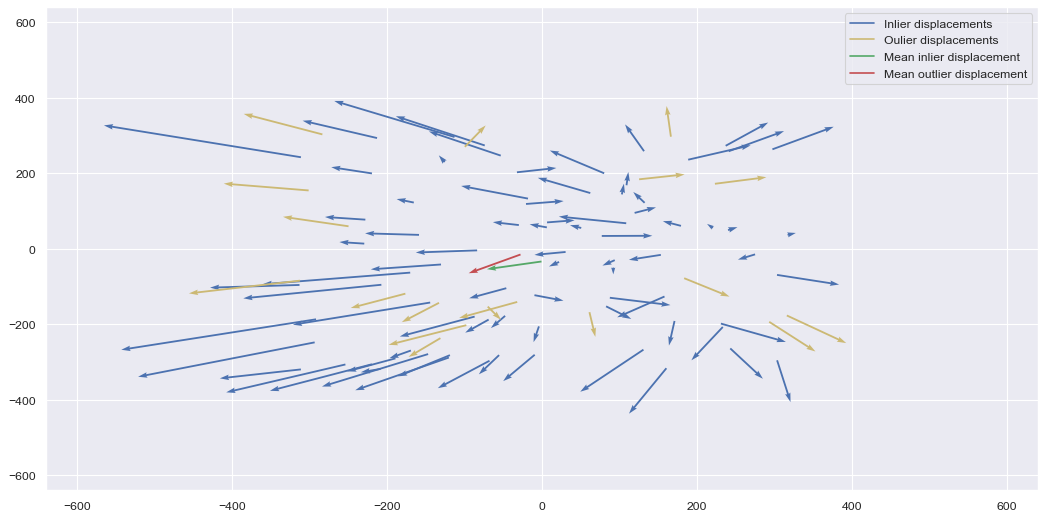

In [165]:
gt, proj, disp, inlier_disp, y_angle, generated_from_inliers = get_displacements(100, (0, 0.1))
print("y angle is: ", y_angle)
plot_displacements(gt, proj, inlier_disp, conf)

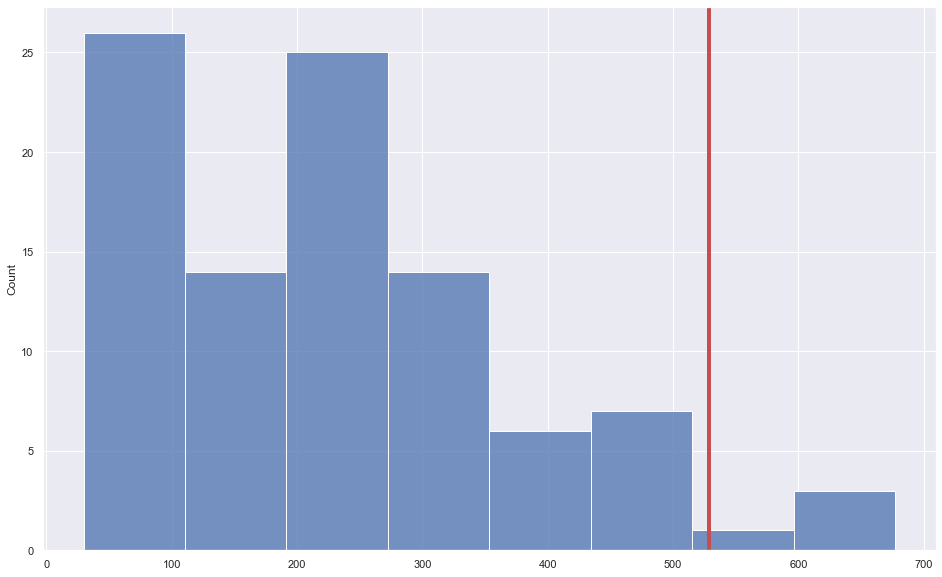

In [166]:
sns.histplot([min(2000, float(elm.norm())) for elm in disp])
plt.axvline(23**2, 0, 1, color='r', linewidth=4)

## Let's use the binding from pyransaclib

! Note that it is modified version available at my github (uses up2p solver instead of p3p) to perform optimization and so on

```
export CMAKE_PREFIX_PATH=/Users/hlovatskyibohdan/lab/pose_estimation/benchmark/PoseLib/_install/lib/cmake/PoseLib
cmake .. && make
```

In [17]:
import pyransaclib

In [13]:
# TODO: refactor this
def run_ransac(xs, Xs, Rg, tg, rand_angle, conf: Config = conf):
    xs = [(elm[0] - conf.img_width // 2, elm[1] - conf.img_height // 2) for elm in xs]
    xs, Xs = list(itertools.chain(*xs)), list(itertools.chain(*Xs))
    xs = np.array([elm.detach().cpu().numpy().astype(np.float64) for elm in xs])
    Xs = np.array([elm.detach().cpu().numpy().astype(np.float64) for elm in Xs])
    img_name = "test_img.png"
    fl = float(conf.focal_length)
    inlier_threshold = 12
    num_lo = 5
    min_iters = int(1e5)
    max_iters = int(1e9)
    ret = pyransaclib.ransaclib_localization(img_name, fl, fl, xs, Xs,\
                                         inlier_threshold, num_lo,\
                                         min_iters, max_iters)
        
    R, t = quaternion_to_matrix(torch.tensor(ret['qvec'])), torch.tensor(ret['tvec'])
    R = R.T
    t = -R @ t
    
    return R, t, ret['num_inliers']

In [19]:
xs, Xs, inliers, Rg, tg, rand_angle = generate_examples(100, (15, 0))
Rg, tg

(tensor([[ 0.9998,  0.0115, -0.0134],
         [ 0.0000, -0.7597, -0.6503],
         [-0.0177,  0.6502, -0.7596]], dtype=torch.float64),
 tensor([0.7355, 0.0336, 0.1428]))

In [20]:
R, t, inliers_count = run_ransac(xs, Xs, Rg, tg, rand_angle, conf)
R, t, inliers_count



 image test_img.png has # 100 matches as input to RANSAC
  test_img.png 184.752 184.752
   test_img.png : running LO-MSAC on 100 matches 
   ... LOMSAC found 80 inliers in 100000 iterations with an inlier ratio of 0.8
   ... LOMSAC took 0.143706 s
   ... LOMSAC executed 7 local optimization stages
  Image test_img.png : we found # 80 inliers
test_img.png -0.346982 0.937835 0.00262255 -0.0078155 -0.731348 -0.0750744 0.139852


(tensor([[ 9.9986e-01,  1.0343e-02, -1.2839e-02],
         [-5.0465e-04, -7.5919e-01, -6.5087e-01],
         [-1.6479e-02,  6.5078e-01, -7.5908e-01]], dtype=torch.float64),
 tensor([0.7338, 0.0337, 0.1430], dtype=torch.float64),
 80)

In [21]:
validate_sol(R,  t, Rg, tg)

(0.08933877685588905, tensor(0.0017, dtype=torch.float64))

## Procrustes problem

y angle is:  tensor([44.])


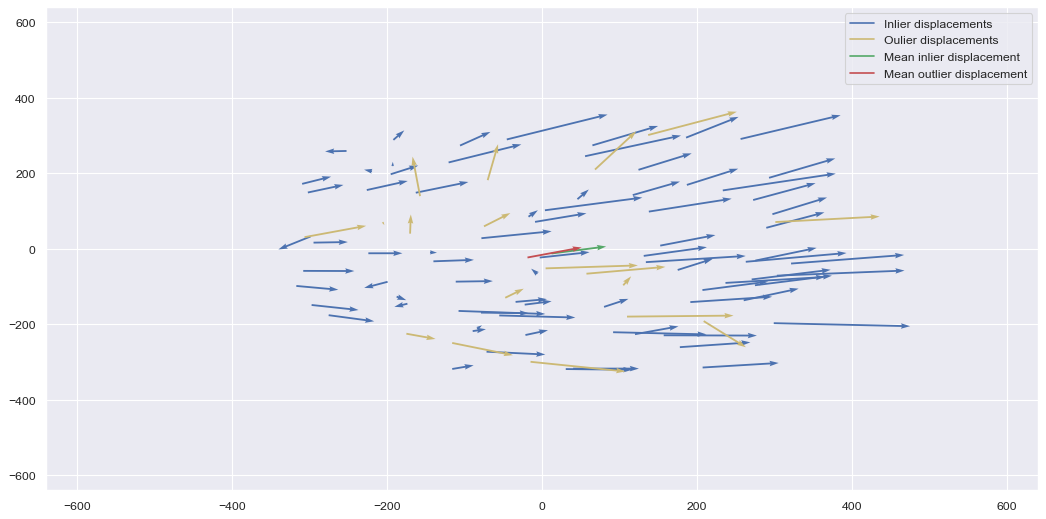

In [172]:
gt, proj, disp, inlier_disp, y_angle, generated_from_inliers = get_displacements(100, (0, 40))
print("y angle is: ", y_angle)
plot_displacements(gt, proj, inlier_disp, conf)

In [174]:
gt = np.array([elm.detach().cpu().numpy() for elm in gt])
proj = np.array([elm.detach().cpu().numpy() for elm in proj])

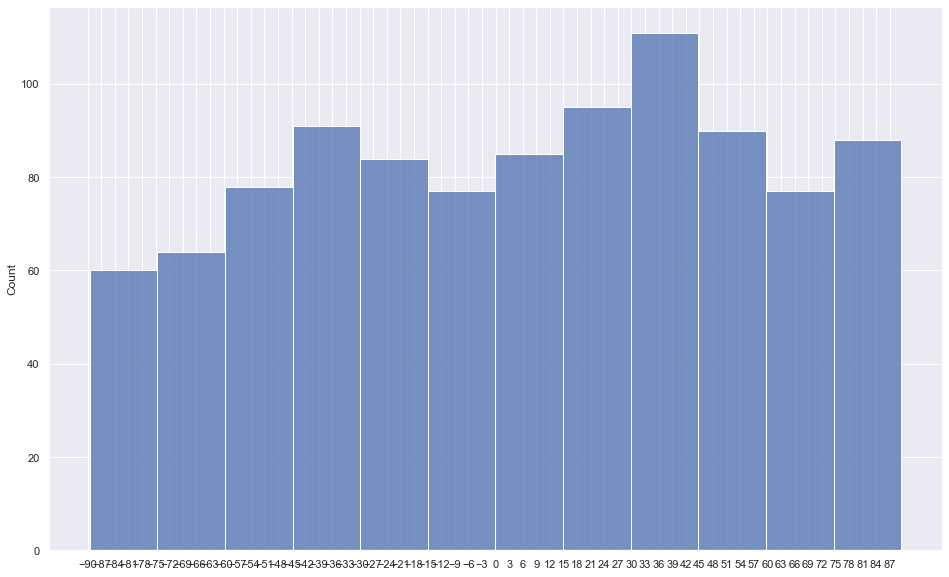

In [175]:
step = 3

Rs, ss = [], []
for i in range(1000):
    idcs = np.random.choice(len(gt), 3)
    
    gtc = gt[idcs] - np.mean(gt[idcs], 0)
    projc = proj[idcs] - np.mean(proj[idcs], 0)
    gtc /= (np.linalg.norm(gtc) + 1e-5)
    projc /= (np.linalg.norm(projc) + 1e-5)
    
    R, s = orthogonal_procrustes(gtc, projc)
    Rs.append(R)
    ss.append(s)

    # measure disparity
    projc = np.dot(projc, R.T) * s
    disparity = np.sum(np.square(gtc - projc))
    

angles = [np.rad2deg(np.arcsin(R[1][0])) for R in Rs]
plt.xticks(np.arange(-90, 90, 3))
ax = sns.histplot(angles)

## Grid change on error

In [187]:
def generate_grid_points(n: int = 3, disp: tuple[float, float] = (0, 0), conf: Config = conf,
                         device: torch.device = device,
                         dtype: torch.dtype = dtype):
    x = np.linspace(-conf.img_width // 2 + conf.img_width // n,
                    conf.img_width // 2 - conf.img_width // n, n)
    y = np.linspace(-conf.img_height // 2 + conf.img_height // n,
                    conf.img_height // 2 - conf.img_height // n, n)
    
    xx, yy = np.meshgrid(x, y)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=80)
    axes.plot(xx, yy, marker='.', color='k', linestyle='none')
    
    xs, Xs = [], []
    for i in range(n):
        for j in range(n):
            xs.append((xx[i][j], yy[i][j]))

    
    R = get_upward_with_dev(0, 0, 0, device, dtype)
    Rerr = get_upward_with_dev(0, disp[0], disp[1], device, dtype)
    t = torch.zeros(3, )
    
    for x in xs:
        X = generate_correspondence(torch.tensor(x), conf)
        X = transform_correspondence(X, R, t)
        Xs.append(X)

    reprojected = []
    for X in Xs:
        x = reproject(X, Rerr, t, conf)
        reprojected.append(tuple(x.detach().cpu().numpy()))
    
    xx, yy = np.array([elm[0] for elm in xs]), np.array([elm[1] for elm in xs])
    xxb, yyb = np.array([elm[0] for elm in reprojected]), np.array([elm[1] for elm in reprojected])
    
    axes.plot(xxb, yyb, marker='.', color='r', linestyle='none')
    
    axes.quiver(xx, yy, xxb - xx, yyb - yy,
                           color='r',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           scale=1,
                           width=1,
                          )
    
    plt.show()
    

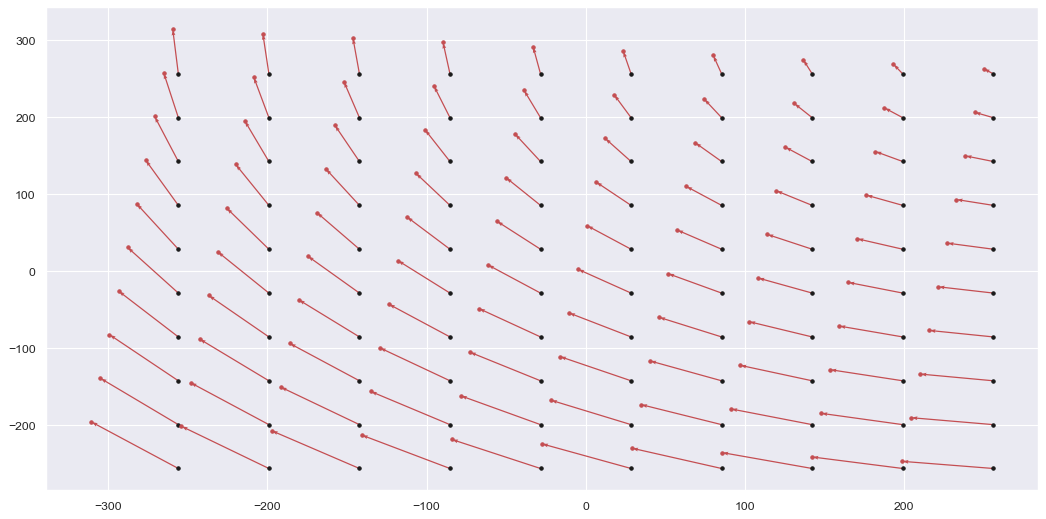

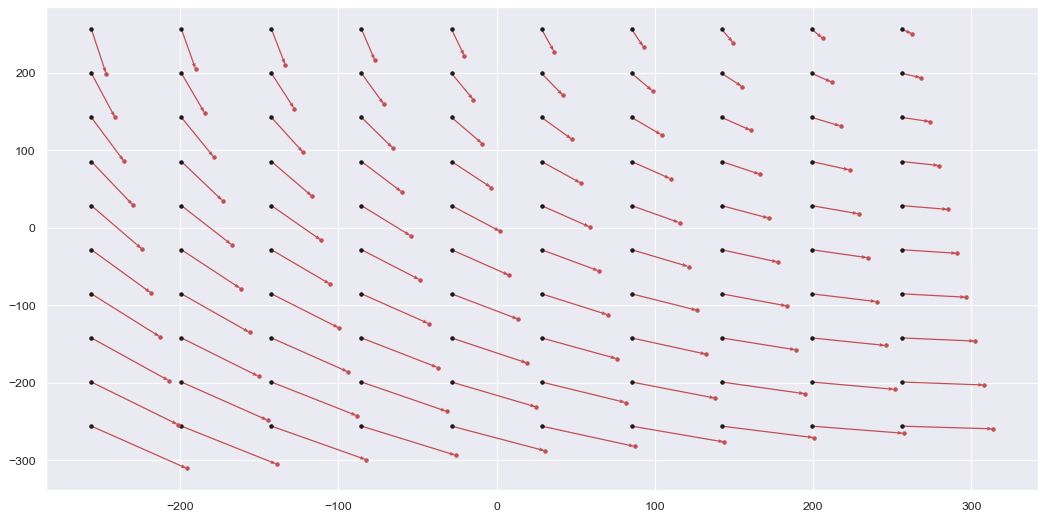

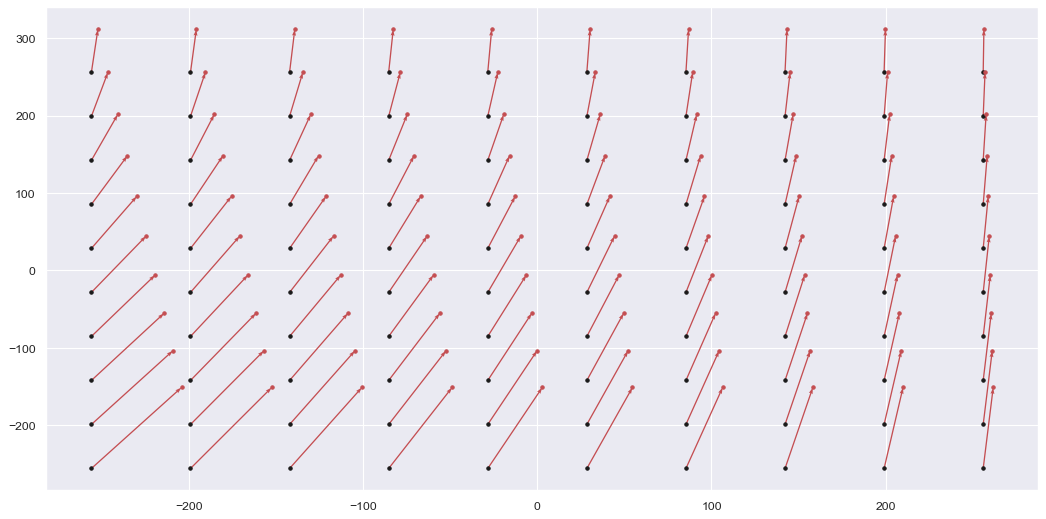

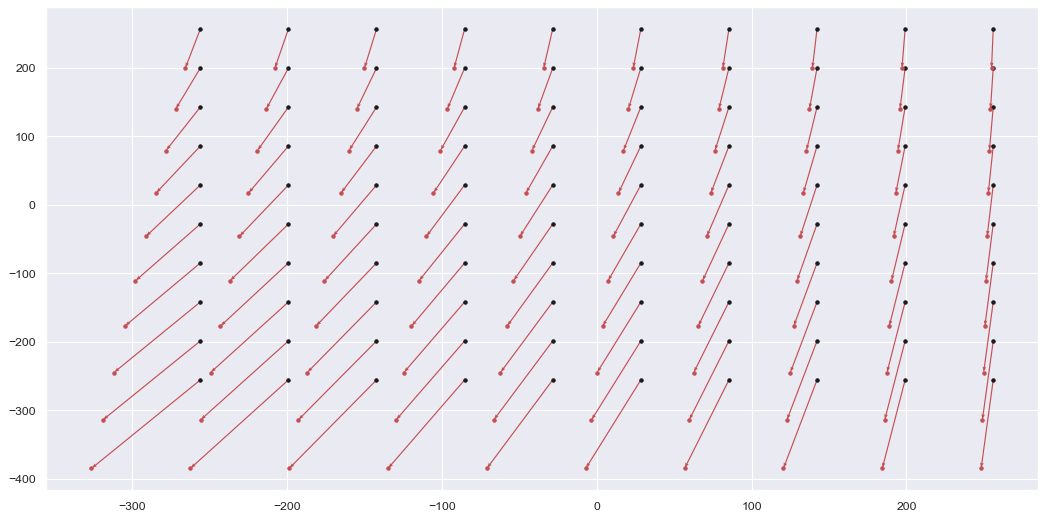

In [193]:
for disp in [(0, 0.1), (0, -0.1), (0.1, 0), (-0.1, 0)]:
    generate_grid_points(n=10, disp=disp)